In [109]:
import numpy as np
import operator

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-10-12 03:04:21,086: Credentials are already in use. The existing account in the session will be replaced.


Task 2 Missing Number
From a function that has as a parameter a vector of positive integers of size 2^n -1, which is missing a number, this vector can be disordered, to search for the missing number from a quantum circuit.


def missing_number(Optional[list,array, str]: input_vector):

“””
 input_vector: List, array or string that contain integer values of size 2^n -1, where are missing a number to obtain all the number 2^n 

Return the positive integer value that is missing in the input.
     “””

- use a framework that works with quantum circuits, qiskit, cirq, pennylane, etc. 
- define a quantum circuit to convert the vector in a quantum circuit
- define an oracle to find the missing value
- encoding the output value in an integer value
- consider print your quantum circuit,


Example:

A =  missing_number([3,0,1])

print(A)

2

Bonus: 

Which is the largest list that can be implemented? Identify it and describe the result

References:

[1] Deutsch, David, and Richard Jozsa. "Rapid solution of problems by quantum computation." Proceedings of the Royal Society of London. Series A: Mathematical and Physical Sciences 439.1907 (1992): 553-558.
[2] Bernstein, Ethan, and Umesh Vazirani. "Quantum complexity theory." SIAM Journal on computing 26.5 (1997): 1411-1473.
[3] Grover, Lov K. , "A fast quantum mechanical algorithm for database search", Proceedings of the 28th Annual ACM Symposium on the Theory of Computing (1996), arXiv:quant-ph/9605043


In [86]:
def vector_to_qc(input_vector: list):
    ''' '''
    n_qbits_adress = np.log(len(input_vector) + 1)/np.log(2)
    n_qbits_adress = np.around(n_qbits_adress).astype(int)
    adress = QuantumRegister(n_qbits_adress, 'adress')
    flag   = QuantumRegister(1, 'flag')
    qc = QuantumCircuit(adress, flag, name="input_vector")
    
    for num in input_vector:
        bits = format(num, f'#0{n_qbits_adress+2}b')[2:]
        bits = list(bits)
        bits = list(reversed(bits))
        
        for i in range(n_qbits_adress):
            if bits[i] == '0':
                qc.x(adress[i])
        qc.mct(adress, flag)
        for i in range(n_qbits_adress):
            if bits[i] == '0':
                qc.x(adress[i])
        qc.barrier()
    return qc

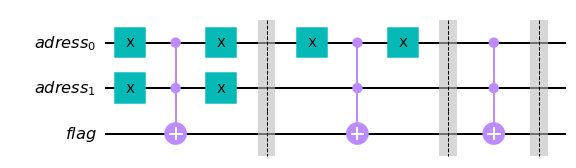

In [87]:
vector_to_qc([0,2,3]).draw()

In [60]:
def diffuser_circ(n_qubits):
    qbits = QuantumRegister(n_qubits)
    qc = QuantumCircuit(qbits, name='diffuser')
    
    # Preparation
    qc.h(qbits)
    qc.barrier()
    # S0
    qc.x(qbits)
    qc.h(qbits[-1])
    qc.mcx(qbits[:-1], qbits[-1])
    qc.h(qbits[-1])
    qc.x(qbits)
    # inverse Preparation
    qc.barrier()
    qc.h(qbits)
    
    return qc

In [93]:
def missing_number_circuit(input_vector: list):
    '''
    input_vector: List, array or string that contain integer values of size 2^n -1, where are missing a number to obtain all the number 2^n 
    '''
    n_qbits_adress = np.log(len(input_vector) + 1)/np.log(2)
    n_qbits_adress = np.around(n_qbits_adress).astype(int)
    
    flag  = QuantumRegister(1, 'flag')
    adress  = QuantumRegister(n_qbits_adress, 'data')
    cr    = ClassicalRegister(n_qbits_adress)
    qc = QuantumCircuit(adress, flag, cr)

    # All adress
    qc.h(adress)
    # Default state of flag -|-> or -1/sqrt(2)*(|0> - |1>)
    qc.x(flag)
    qc.h(flag)
    qc.x(flag)
    qc.barrier()
    
    oracle = vector_to_qc(input_vector)

    diffuser = diffuser_circ(n_qubits = n_qbits_adress)

    qc = qc.compose(oracle, adress[:] + flag[:])
    qc.barrier()
    qc = qc.compose(diffuser, adress[:])

    qc.measure(adress, cr)
    return qc
    #qc.draw()

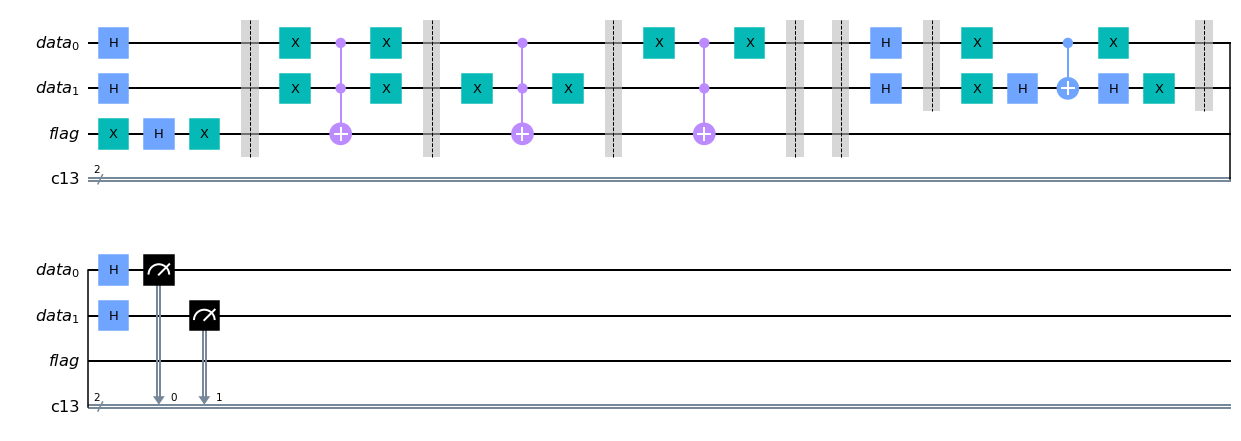

In [115]:
qc = missing_number_circuit([0,1,2])
qc.draw()

In [116]:
def test_circuit(qc, shots=1000, decimal=True):
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend=backend, shots=shots, seed_simulator=12346)
    result = job.result()
    count = result.get_counts()
    if decimal:
        count = {str(int(key, 2)):value for key,value in count.items()}
    return count

In [117]:
test_circuit(qc, shots=8000)

{'3': 8000}

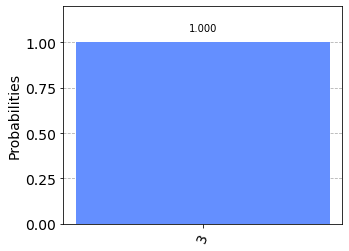

In [118]:
plot_histogram(test_circuit(qc, shots=8000), figsize=(5,4))

In [142]:
def missing_number(input_vector: list):
    '''
    input_vector: List, array or string that contain integer values of size 2^n -1, where are missing a number to obtain all the number 2^n.
    Return the positive integer value that is missing in the input.
    '''
    qc = missing_number_circuit(input_vector)
    shots = 1000 * len(input_vector)
    count = test_circuit(qc, shots=1000, decimal=True)
    return max(count.items(), key=operator.itemgetter(1))[0]

In [144]:
missing_number([0,2,3,4,5,6,7,8,9,10,11,12,13,14,15])

'1'

# Which is the largest list that can be implemented?
Supposing 127 qubits (IBM Eagle) as the largest quantum computer to this day (Oct 2022), then:

We need 1 qubit for the flag, leaving 126 qubits for encoding the list of numbers.

In [5]:
2**126

85070591730234615865843651857942052864

85070591730234615865843651857942052864 is the biggest number that can be encoded.

Therefore, if we assume starting at 0, we can encode a list of length of that number, minus 1.

In [8]:
import qiskit.tools.jupyter
%qiskit_version_table